In [2]:
# import libraries
from sklearn.datasets import fetch_openml

# load dataset
mnist = fetch_openml('mnist_784', as_frame=False)

c:\Users\silva\anaconda3\envs\dev\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# create features and targets
X, y = mnist.data, mnist.target
#review
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape # 70000 images with 784 features = 28 * 28 pixels

(70000, 784)

In [5]:
y.shape

(70000,)

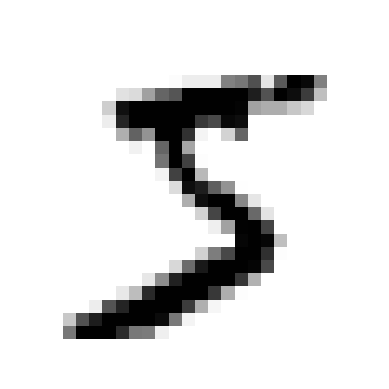

In [6]:
# look at one digit
import matplotlib.pyplot as plt

def plot_image(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_image(some_digit)
plt.show()

In [7]:
# verify what target is 
y[0]

'5'

In [8]:
# manually split training and testing data
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##### Begin Training a Binary Classifier

In [9]:
# create target vector for 5
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [10]:
# import stochastic gradient descent model
from sklearn.linear_model import SGDClassifier

# create and fit model
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# predict if our digit from earlier is 5
pred_5 = sgd_clf.predict([some_digit])
print(pred_5)

[ True]


##### Get Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

[0.95035 0.96035 0.9604 ]


This model is ~95% accurate on the training data. It seems overfit. How can we ge sure this is real and not do to a data imbalance or somethin else.

In [12]:
# test using a dummy classifier
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # if no 5s detected it will print false
print(cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy"))

False
[0.90965 0.90965 0.90965]


Just guessing not 5 every time will give you an accuracy of 90% due to only 10% of the data being actual 5s.

##### Confusion Matrix Metric

In [13]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics  import confusion_matrix

# create training prediction
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# create confusion matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [14]:
# create perfect predictions
y_train_perfect_pred = y_train_5
# show what a confusion matrix would look like with perfect predictions
cm_perf = confusion_matrix(y_train_5, y_train_perfect_pred)
cm_perf

array([[54579,     0],
       [    0,  5421]], dtype=int64)

##### Precision and Recall

Accuracy of positive predictions is called precision

$P = \frac{TP}{TP+FP}$

Sensitivity or Recall is the ratio of positive instances correctly detected by the classifier

$recall = \frac{TP}{TP+FN}$

In [15]:
# sklearn has packages for this
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)
print("precision score = %f" %(precision))
print("recall score = %f" %(recall))

precision score = 0.837088
recall score = 0.651171


Not actually as good as 95% accuracy. We can see precision and recall are lower than the plain accuracy of our classifier.

##### F1 - Score

$F_{1} = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}\times \frac{precision\times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$

Combination of both precision and recall. This is the *harmonic mean* of precision and recall. This gives more weight to lower values meaning a high F1 score is only possible if both the precision and recall are both high.

In [16]:
# compute F1 score
from sklearn.metrics import f1_score
print("F1 score is %f" %(f1_score(y_train_5, y_train_pred)))

F1 score is 0.732517


This is a more accurate reflection of how well our model performs. 

#####  Precision/Recall Tradeoff

In [17]:
# look at the decision function
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred # will the score be greater than the threshold for detection

[2164.22030239]


array([ True])

In [18]:
# if we set a higher threshold what will happen
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [19]:
from sklearn.metrics import precision_recall_curve

# modify our cross val score to use decision functions instead of accuracy
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# get thresholds, precisions and recalls
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

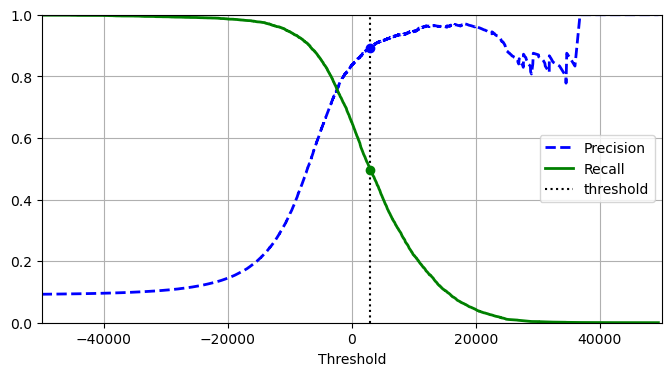

In [20]:
# Plot the precision recall curve
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")


plt.show()

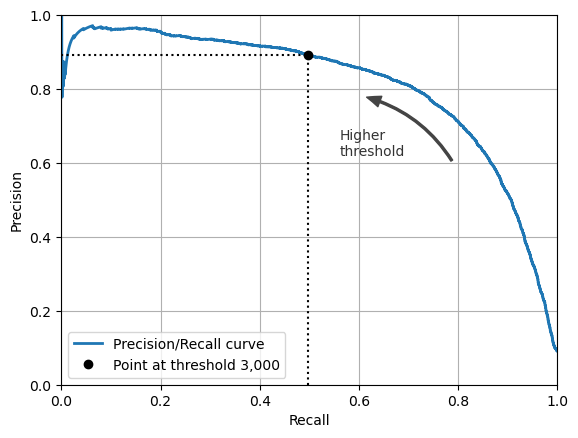

In [21]:
# plot the precision against recall
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

There will always be a tradeoff between precision and recall. Maximizing either one will depend on the business question at hand. Having these visualizations help us determine where we want to make these cutoffs.

In [22]:
# Search for the lowest threshold that gives at least a 90% precision
idx_for_90_precision = (precisions >= .9).argmax()
threshold_for_90 = thresholds[idx_for_90_precision]
threshold_for_90

3370.0194991439557

In [24]:
# to make predictions on the training set we can now use the theshold as follows
y_train_pred_90 = (y_scores >= threshold_for_90)
print(precision_score(y_train_5, y_train_pred_90))
recall_at_90 = recall_score(y_train_5, y_train_pred_90)
print(recall_at_90)

0.9000345901072293
0.4799852425751706


Our precision at this threhold is 90%, but our recall is only 48%. 

##### ROC Curve

ROC = "Receiver Operator Characteristic"
Statistic used in binary classification. Plot the True Positive Rate (recall) against the False Positive Rate (fallout or 1-specificity/true negative rate).
True negative rate is the ratio of negative instances correctly classified as negative. It is the recall vs 1-specificity.

In [25]:
from sklearn.metrics import roc_curve

# get the TPR, FPR
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

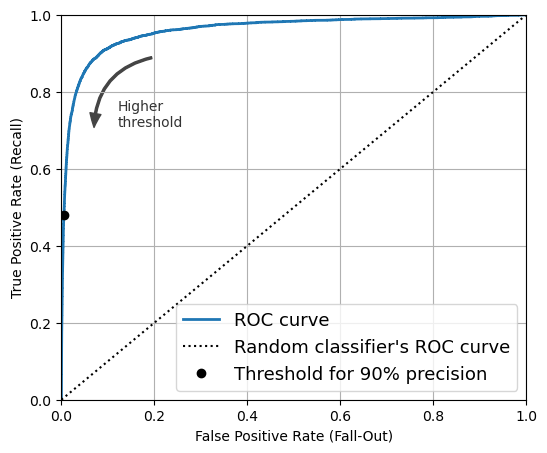

In [26]:
# plot the ROC curve
idx_for_threshold_at_90 = (thresholds <= threshold_for_90).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

The dotted line represents a classifier that uses random guessing and the blue line is a near perfect model. To get information from this graph we plot the Area Under the Curve (AUC) 

##### Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

# create instance 
forest_clf = RandomForestClassifier(random_state=42)
# predict probabilities
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [29]:
# look at probabilities for first two images of training set [Neg, Pos]
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The first image has an 89% estimated probability of being positive as 5 and the second image has a 99% proability of not being a 5.